## Importing All Libraries

In [1]:
import tensorflow as tf
import keras 
import pandas as pd
import itertools
import numpy as np 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

Using TensorFlow backend.


In [2]:
#These are the categories we are predicting for

organelles= ['cytoplasm', 'endosome', 'er', 'golgi', 'mitochondrion', 'nucleus']

In [3]:
# dimensions of our images.  
img_width, img_height = 64, 64  
   
top_model_weights_path = '1bottleneck_fc_model.h5'  
train_data_dir = 'data/train'  
validation_data_dir = 'data/validate'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 50  
# batch size used by flow_from_directory and predict_generator  
batch_size = 100

In [4]:
#Loading vgc16 model
vgc_16 = applications.VGG16(include_top=False, weights='imagenet')

In [5]:
datagen = ImageDataGenerator(rotation_range=90, horizontal_flip=True)

## Creating the Transfer Learning System

This takes time to run, but once the npy files have been created, no need to run them again

In [ ]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode='categorical',  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgc_16.predict_generator(generator, predict_size_train)  
   
np.save('1bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

In [ ]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgc_16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('1bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

In [ ]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgc_16.predict_generator(  
     generator, predict_size_test)  
   
np.save('1bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

## Loading up all the data into the transfer learning system

In [6]:
datagen_top = ImageDataGenerator() 

In [7]:
#training data
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
train_data = np.load('1bottleneck_features_train.npy')  
   
train_labels = generator_top.classes  
   
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 9625 images belonging to 6 classes.


In [8]:
#validation data
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('1bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 1492 images belonging to 6 classes.


In [9]:
#testing data
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,    
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=True)  
   
nb_test_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
test_data = np.load('1bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
   
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 120 images belonging to 6 classes.


## Model Fitting 

Only showing the best model

Creating the machine model

In [30]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.33))
model.add(Dense(500, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy']) 

Fitting our data to the machine model

In [31]:
start = datetime.datetime.now()
history = model.fit(train_data, train_labels,  
      epochs=20,  
      batch_size=500,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/20
9625/9625 [==============================] - 33s 3ms/step - loss: 9.3106 - acc: 0.1917 - val_loss: 3.5098 - val_acc: 0.2044
Epoch 2/20
9625/9625 [==============================] - 27s 3ms/step - loss: 4.1137 - acc: 0.2123 - val_loss: 1.7719 - val_acc: 0.2165
Epoch 3/20
9625/9625 [==============================] - 32s 3ms/step - loss: 2.0186 - acc: 0.2521 - val_loss: 1.7634 - val_acc: 0.2259
Epoch 4/20
9625/9625 [==============================] - 27s 3ms/step - loss: 1.7677 - acc: 0.2811 - val_loss: 1.7475 - val_acc: 0.2473
Epoch 5/20
9625/9625 [==============================] - 27s 3ms/step - loss: 1.6916 - acc: 0.3029 - val_loss: 1.7638 - val_acc: 0.2420
Epoch 6/20
9625/9625 [==============================] - 30s 3ms/step - loss: 1.6482 - acc: 0.3186 - val_loss: 1.7411 - val_acc: 0.2473
Epoch 7/20
9625/9625 [==============================] - 27s 3ms/step - loss: 1.6111 - acc: 0.3396 - val_loss: 1.7230 - val_acc: 0.2587
Epoch 8

Plotting the accuracy and loss of both training and validation set

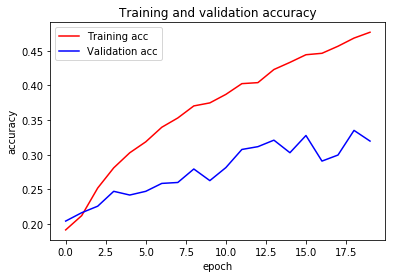

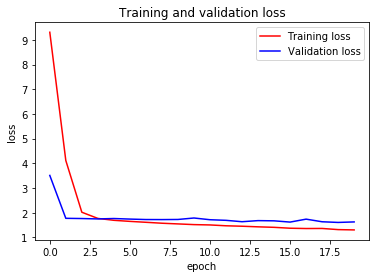

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

Predicting our data on unseen test set

In [40]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[2.9873241424560546, 0.25833333333333336]

## Classification and Confusion Matrix of our Data

Classification

In [41]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds, target_names=organelles)
print(classification_metrics)

               precision    recall  f1-score   support

    cytoplasm       0.50      0.05      0.09        20
     endosome       0.00      0.00      0.00        20
           er       0.00      0.00      0.00        20
        golgi       0.18      0.60      0.28        20
mitochondrion       0.50      0.05      0.09        20
      nucleus       0.00      0.00      0.00        20

    micro avg       0.20      0.12      0.15       120
    macro avg       0.20      0.12      0.08       120
 weighted avg       0.20      0.12      0.08       120
  samples avg       0.12      0.12      0.12       120



Confusion Matrix

In [42]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

TypeError: 'numpy.ndarray' object is not callable

In [43]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=True,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


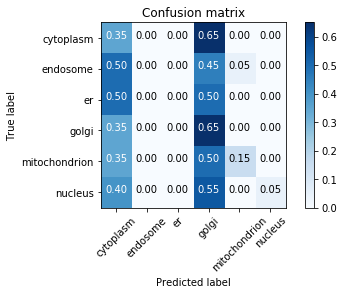

In [44]:
plot_confusion_matrix(confusion_matrix, organelles)

## Testing Images on Model

In [45]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [46]:
def test_single_image(path):
    organelles 
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgc_16.predict(images)  
    preds = model.predict_proba(bt_prediction)
    for idx, organelle, x in zip(range(0,6), organelles , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, organelle, round(x*100,2) ))
    print('Final Decision:')
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

[INFO] loading and preprocessing image...
ID: 0, Label: cytoplasm 0.0%
ID: 1, Label: endosome 0.0%
ID: 2, Label: er 0.0%
ID: 3, Label: golgi 99.74%
ID: 4, Label: mitochondrion 0.26%
ID: 5, Label: nucleus 0.0%
Final Decision:
ID: 3, Label: golgi


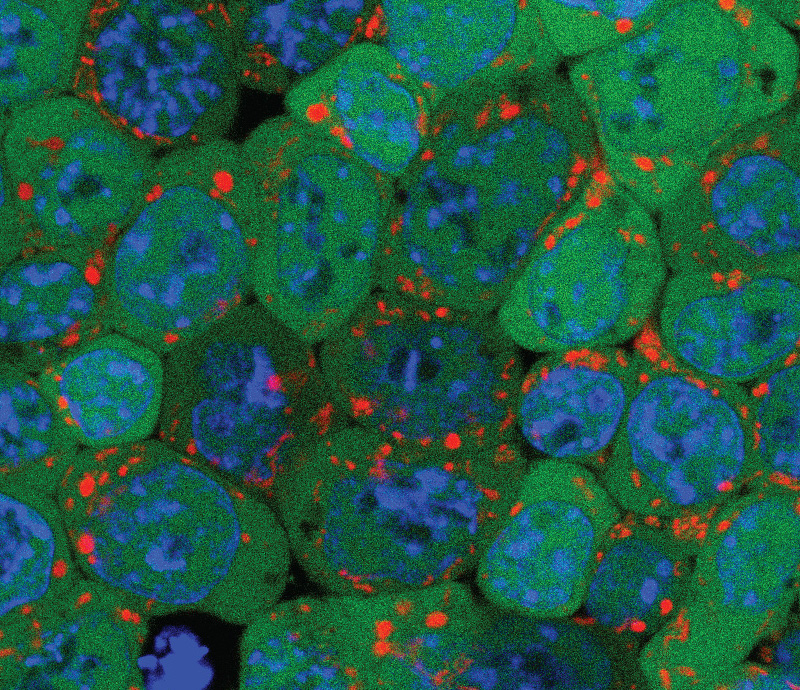

In [48]:
path = 'mitochondria.jpg'


test_single_image(path)

## Conclusion:

While my machine can predict with a 30% or more success rate, it is a poor model. Randomly, the chance of guessing an organelle correctly is 16.6%, so this machine should be able to predict twice as well as randomly guessing. However, in my test sets, it only picks one of the labels and nothing else.

The biggest reason for this is picture resolution. The pictures were poor quality making it difficult for my algorithm to pick up each organnelles. In addition, it appears that some pictures may have been labeled incorrectly, as observed when looking at individual pictures. Looking at our classification, we can see the same result. With poor precisions, it failed to classify each labels properly. I ran the test set with even more pictures, but found results to be similar to this set of results. Also, the protein marker used to tag each organelles might have also tagged unintended targets. It is impossible to know without higher resolution pictures. With this restriction, I could not improve my model any further.